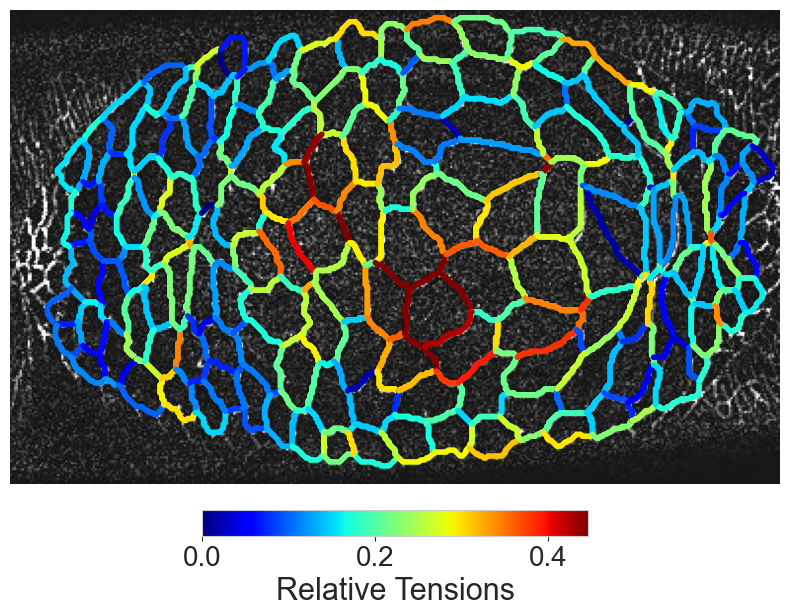

In [89]:
import pickle

# Abre el archivo .pkl y carga su contenido en una variable
#with open(r'C:\Users\Ander\Documents\TFM\STRESS\colonies_STRESS.pkl', 'rb') as f:
with open(r'C:\Users\Jon\Documents\Master Biofísica\TFM\PELIS MOSCAS - ORIGINALES\22126 271022 c381 ECadGFP\\2-\colonies_DLITE_20-46.pkl', 'rb') as f:
    data = pickle.load(f)  
    
# Ruta de la imagen
#path_to_image = r'C:\Users\Jon\Documents\Master Biofísica\TFM\PELIS MOSCAS - ORIGINALES\22126 271022 c381 ECadGFP\2-\2- filtro\2 - 22126 271022 001 - RESTA - horizontal - CROP - T=58.tif'
path_to_image = r'C:\Users\Jon\Documents\Master Biofísica\TFM\DOCUMENTOS\imagenes\preuba.jpg'


%matplotlib inline
key_time = '11'

    
    
def obtener_informacion_limitada(datos):
    informacion_tiempos = {}

    time_obj = datos[key_time]
    informacion_celulas = {}
    
    # Limitamos el bucle a las primeras 3 células
    for i, cell in enumerate(time_obj.cells[:]):
        info_celula = {}
        
        info_celula['_pressure'] = cell._pressure
        
        info_celula['edges'] = []
        
        # Limitamos el bucle al primer 'edge' de cada célula
        for edge_index, edge in enumerate(cell.edges[:]):
            
            edge_info = {'Tension':edge._tension,'x_co_ords': edge.x_co_ords, 'y_co_ords': edge.y_co_ords}
            
            info_celula['edges'].append(edge_info)
        
        informacion_celulas[i] = info_celula

    informacion_tiempos[key_time] = informacion_celulas

    return informacion_tiempos

info_limitada = obtener_informacion_limitada(data)

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.patches import Ellipse, Polygon
from PIL import Image, ImageDraw
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase

def calculate_polygon_pixels_and_centroid(x_coords, y_coords):
    image = Image.new('L', (max(x_coords)+1, max(y_coords)+1), 0)
    ImageDraw.Draw(image).polygon(list(zip(x_coords, y_coords)), outline=1, fill=1)
    pixels = np.array(image).nonzero()
    pixel_count = len(pixels[0])
    centroid_x = np.mean(pixels[1])
    centroid_y = np.mean(pixels[0])
    return pixel_count, (centroid_x, centroid_y)

def calculate_stress_tensor(cell_info, cell_properties):
    stress_tensor = np.zeros((2, 2))
    for edge in cell_info['edges']:
        vector_ij = np.array([edge['x_co_ords'][-1] - edge['x_co_ords'][0], edge['y_co_ords'][-1] - edge['y_co_ords'][0]])
        T = edge['Tension']
        stress_tensor += T * np.outer(vector_ij, vector_ij) / np.linalg.norm(vector_ij)
    stress_tensor -= np.abs(cell_info['_pressure']) * cell_properties["area"] * np.eye(2)
    eigenvalues, eigenvectors = np.linalg.eig(stress_tensor)
    return stress_tensor, eigenvalues, eigenvectors

data=info_limitada
frame_id = key_time
cell_properties = {}

fig, ax = plt.subplots(figsize=(8,7))

vector_limit = 100

# Compute the total tissue area
total_area = 0

# Prepare color maps
cmap_edge = cm.get_cmap('jet')
cmap_cell = cm.get_cmap('jet')

# Gather all the tension and pressure values
all_tensions = [edge['Tension'] for cell_info in data[frame_id].values() for edge in cell_info['edges']]
all_pressures = [cell_info['_pressure'] for cell_info in data[frame_id].values()]

# Calculate Q1, Q3, and the IQR for tension
Q1_tension = np.percentile(all_tensions, 25)
Q3_tension = np.percentile(all_tensions, 75)
IQR_tension = Q3_tension - Q1_tension

# Calculate Q1, Q3, and the IQR for pressure
Q1_pressure = np.percentile(all_pressures, 25)
Q3_pressure = np.percentile(all_pressures, 75)
IQR_pressure = Q3_pressure - Q1_pressure

# Define the upper and lower bounds for non-outlier tensions
upper_bound_tension = Q3_tension + 1.5 * IQR_tension
lower_bound_tension = max(0, Q1_tension - 1.5 * IQR_tension) # We use max to ensure the lower bound isn't negative

# Define the upper and lower bounds for non-outlier pressures
upper_bound_pressure = Q3_pressure + 1.5 * IQR_pressure
lower_bound_pressure = Q1_pressure - 1.5 * IQR_pressure # We use max to ensure the lower bound isn't negative

# Set these as the min and max for the color mapping
norm_tension = Normalize(lower_bound_tension, upper_bound_tension)
norm_pressure = Normalize(lower_bound_pressure, upper_bound_pressure)

for cell_id, cell_info in data[frame_id].items():
    cell_pressure = cell_info['_pressure']
    cell_edges = cell_info['edges']

    all_x_coords = [edge['x_co_ords'] for edge in cell_edges]
    all_y_coords = [edge['y_co_ords'] for edge in cell_edges]
    all_x_coords = [x for sublist in all_x_coords for x in sublist]
    all_y_coords = [y for sublist in all_y_coords for y in sublist]

    points = np.array([all_x_coords, all_y_coords]).T
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]

    area, (center_x, center_y) = calculate_polygon_pixels_and_centroid(polygon_points[:,0], polygon_points[:,1])
    total_area += area

    cell_properties[cell_id] = {
        "area": area,
        "centroid": (center_x, center_y),
    }

    color = cmap_cell(norm_pressure(cell_pressure))
    polygon = Polygon(polygon_points, closed=True, color=color, alpha=0.2)
    #ax.add_patch(polygon)

    for edge in cell_edges:
        edge_tension = edge['Tension']
        edge_x_coords = edge['x_co_ords']
        edge_y_coords = edge['y_co_ords']

        color = cmap_edge(norm_tension(edge_tension))
        plt.plot(edge_x_coords, edge_y_coords, color=color,linewidth=4)

    stress_tensor, eigenvalues, eigenvectors = calculate_stress_tensor(cell_info, cell_properties[cell_id])

# Leer la imagen
image = plt.imread(path_to_image)

# Ajusta los límites del eje para que coincidan con el tamaño de la imagen
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)

# Mostrar la imagen
plt.imshow(image, cmap='gray', extent=[0, image.shape[1], image.shape[0], 0])

# Creando un objeto ScalarMappable para la tensión
sm_tension = cm.ScalarMappable(cmap=cmap_edge, norm=norm_tension)
sm_tension.set_array([])
cbar_tension = plt.colorbar(sm_tension, orientation='horizontal', label='Tension', shrink=0.5, pad=0.04, aspect=15)
#cbar_tension.ax.set_aspect(0.06)
cbar_tension.ax.tick_params(labelsize=20)
cbar_tension.set_label('Relative Tensions', size=22)

# Creando un objeto ScalarMappable para la presión
#sm_pressure = cm.ScalarMappable(cmap=cmap_cell, norm=norm_pressure)
#sm_pressure.set_array([])
#cbar_pressure = plt.colorbar(sm_pressure, orientation='vertical', label='Pressure', alpha=0.2, shrink=0.5)
#cbar_tension.ax.set_aspect(0.12)
#cbar_tension.set_label('Tension', size=25)  # Aumenta el tamaño de la fuente aquí

plt.xlim(0, 390)
plt.ylim(0, 240)
plt.gca().invert_yaxis()
ax.axis('off')
plt.xticks([]) # Eliminar las marcas en el eje x
plt.yticks([]) # Eliminar las marcas en el eje y
plt.tight_layout() # Asegura que todo encaje en la figura
plt.show()

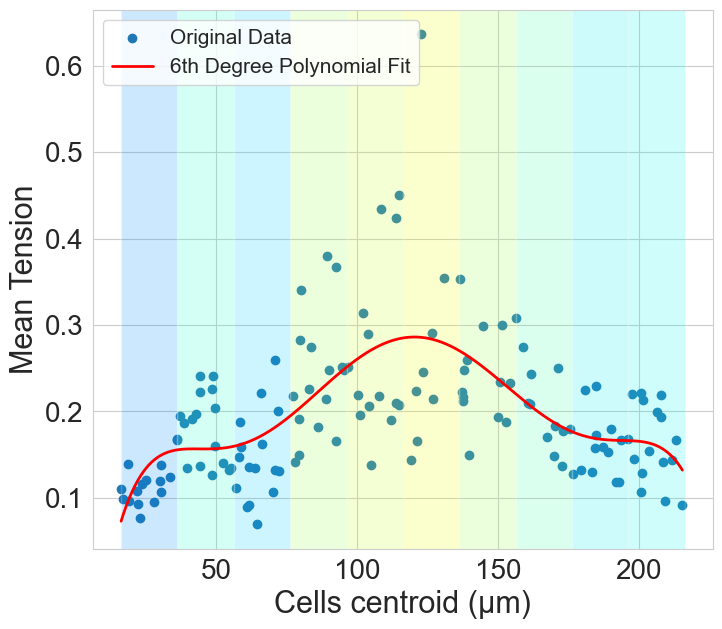

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

scale = 1.7551
# Crear una lista para guardar los datos
data_list = []

for cell_id, cell_info in data[frame_id].items():
    cell_properties_data = cell_properties[cell_id]
    centroid_position = cell_properties_data["centroid"]
    edge_ids = [i for i, _ in enumerate(cell_info['edges'])]
    edge_tensions = [edge['Tension'] for edge in cell_info['edges']]
    mean_tension = np.mean(edge_tensions)
    
    pressure = cell_info['_pressure'] # Extraer la información de la presión
    area = cell_properties_data["area"]
    
    # Agregar la información a la lista de datos
    data_list.append([cell_id, centroid_position, edge_ids, edge_tensions, mean_tension, pressure, area])


# Creating a DataFrame
columns = ['Cell_ID', 'Centroid_Position', 'Edge_IDs', 'Edge_Tensions', 'Mean_Tension', 'Pressure', 'Area']
cell_dataframe = pd.DataFrame(data_list, columns=columns)

cell_dataframe['Centroid_Position'] = cell_dataframe['Centroid_Position'].apply(lambda x: (x[0] / scale, x[1] / scale))

# Convertir el área a micrómetros cuadrados
cell_dataframe['Area'] = cell_dataframe['Area'] / (scale ** 2)


# Extraer las coordenadas X e Y
x_values = cell_dataframe['Centroid_Position'].apply(lambda x: x[0]).values
y_values = cell_dataframe['Mean_Tension'].values

# Ajustar un polinomio de grado 6
coefficients = np.polyfit(x_values, y_values, 6)

# Crear una función polinómica a partir de los coeficientes
polynomial_function = np.poly1d(coefficients)

# Evaluar el polinomio en un rango de valores (más puntos para una curva más suave)
x_fit = np.linspace(min(x_values), max(x_values), 10000)
y_fit = polynomial_function(x_fit)

# Graficar los datos originales
plt.figure(figsize=(8,7))
plt.scatter(x_values, y_values, label='Original Data')

# Graficar el polinomio ajustado con una línea roja más gruesa
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='6th Degree Polynomial Fit')

# (Opcional) Limitar el eje Y si es necesario
# plt.ylim(lower_bound, upper_bound)
# Tamaño del segmento
segment_size = 20

# Valores máximos y mínimos en el eje X
min_x = min(cell_dataframe['Centroid_Position'].apply(lambda x: x[0]))
max_x = max(cell_dataframe['Centroid_Position'].apply(lambda x: x[0]))

# Dividir el eje X en segmentos y calcular la tensión media para cada segmento
for start_x in np.arange(min_x, max_x, segment_size):
    end_x = start_x + segment_size
    segment_cells = cell_dataframe[cell_dataframe['Centroid_Position'].apply(lambda x: start_x <= x[0] < end_x)]
    mean_tension = segment_cells['Mean_Tension'].mean()

    if not np.isnan(mean_tension):  # Evitar segmentos sin células
        color = cmap_edge(norm_tension(mean_tension))
        plt.axvspan(start_x, end_x, facecolor=color, alpha=0.2)

plt.xlabel('Cells centroid (\u03BCm)', fontsize=22)
plt.ylabel('Mean Tension', fontsize=22)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=20) 

plt.show()


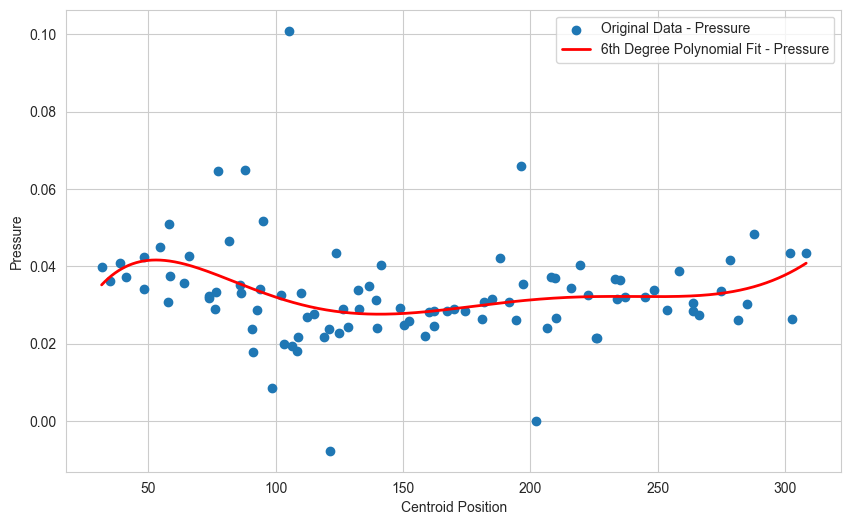

In [53]:
# Extraer las coordenadas X e Y para la presión
x_values_pressure = cell_dataframe['Centroid_Position'].apply(lambda x: x[0]).values
y_values_pressure = cell_dataframe['Pressure'].values

# Ajustar un polinomio de grado 6 para la presión
coefficients_pressure = np.polyfit(x_values_pressure, y_values_pressure, 6)

# Crear una función polinómica a partir de los coeficientes para la presión
polynomial_function_pressure = np.poly1d(coefficients_pressure)

# Evaluar el polinomio en un rango de valores para la presión
x_fit_pressure = np.linspace(min(x_values_pressure), max(x_values_pressure), 10000)
y_fit_pressure = polynomial_function_pressure(x_fit_pressure)

# Graficar los datos originales de la presión
plt.figure(figsize=(10,6))
plt.scatter(x_values_pressure, y_values_pressure, label='Original Data - Pressure')

# Graficar el polinomio ajustado con una línea roja más gruesa para la presión
plt.plot(x_fit_pressure, y_fit_pressure, color='red', linewidth=2, label='6th Degree Polynomial Fit - Pressure')

# (Opcional) Limitar el eje Y si es necesario para la presión
# plt.ylim(lower_bound_pressure, upper_bound_pressure)

plt.xlabel('Centroid Position')
plt.ylabel('Pressure')
#plt.title('Pressure vs Centroid Position (6th Degree Polynomial Fit)')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


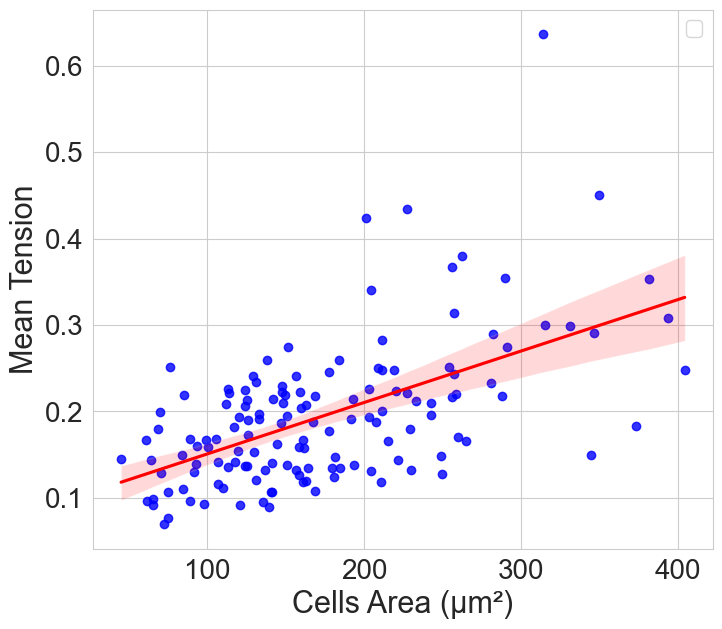

Correlación de Pearson: 0.5629065565138656
Valor-p: 4.5219921691041513e-13


In [93]:
import seaborn as sns
from scipy import stats

# Configuring the plot styles
sns.set_style("whitegrid")

plt.figure(figsize=(8,7))

# Creating a scatterplot with a regression line
sns.regplot(x=cell_dataframe['Area'], y=cell_dataframe['Mean_Tension'], scatter_kws={"color": "blue"}, line_kws={"color": "red"})

#plt.title('Mean Tension vs Area per Cell')
plt.xlabel('Area')
plt.ylabel('Mean Tension')

# Calculating Pearson's correlation and the p-value
correlation, p_value = stats.pearsonr(cell_dataframe['Area'], cell_dataframe['Mean_Tension'])
# Adding the correlation and p-value inside the plot
#plt.text(x=min(cell_dataframe['Area']), y=max(cell_dataframe['Mean_Tension']) * 0.9, 
#         s=f"Pearson Corr.: {correlation:.2f}\np- value: {p_value:.2e}", 
#         fontsize=18, ha='left', va='center', bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel('Cells Area (\u03BCm\u00B2)', fontsize=22)
plt.ylabel('Mean Tension', fontsize=22)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=20) 
plt.show()

print(f"Correlación de Pearson: {correlation}")
print(f"Valor-p: {p_value}")

# ANGULOS

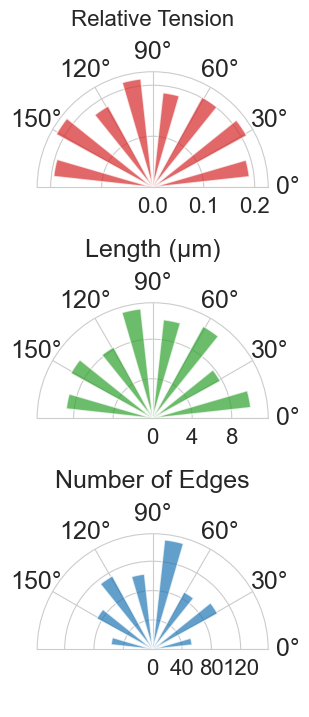

Correlación de Pearson entre todos los parámetros y compuestos:
                 Tension    EdgeID    Length  Tension_EdgeID  EdgeID_Length  \
Tension         1.000000 -0.177728  0.197430        0.045506      -0.087500   
EdgeID         -0.177728  1.000000  0.032290        0.974711       0.931952   
Length          0.197430  0.032290  1.000000        0.080406       0.387855   
Tension_EdgeID  0.045506  0.974711  0.080406        1.000000       0.926607   
EdgeID_Length  -0.087500  0.931952  0.387855        0.926607       1.000000   
Tension_Length  0.584351 -0.047173  0.909567        0.086736       0.284112   

                Tension_Length  
Tension               0.584351  
EdgeID               -0.047173  
Length                0.909567  
Tension_EdgeID        0.086736  
EdgeID_Length         0.284112  
Tension_Length        1.000000  


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

# Crear una lista para guardar los datos
data_list = []

for cell_id, cell_info in data[frame_id].items():
    cell_properties_data = cell_properties[cell_id]
    # Convierte las coordenadas del centroide a micrómetros
    centroid_position = [coordinate / scale for coordinate in cell_properties_data["centroid"]]
    
    # Convierte el área a micrómetros cuadrados
    area = cell_properties_data["area"] / (scale ** 2)
    #centroid_position = cell_properties_data["centroid"]
    edge_ids = [i for i, _ in enumerate(cell_info['edges'])]
    edge_tensions = [edge['Tension'] for edge in cell_info['edges']]
    mean_tension = np.mean(edge_tensions)
    pressure = cell_info['_pressure']
    #area = cell_properties_data["area"]
    
    # Calcula los ángulos y las longitudes para los bordes de esta celda
    angles = []
    lengths = []
    for edge in cell_info['edges']:
        edge_x_coords = edge['x_co_ords']
        edge_y_coords = edge['y_co_ords']

        length = 0
        for i in range(len(edge_x_coords) - 1):
            length += euclidean((edge_x_coords[i], edge_y_coords[i]), (edge_x_coords[i + 1], edge_y_coords[i + 1]))
        lengths.append(length/scale)

        x_start, y_start = edge_x_coords[0], edge_y_coords[0]
        x_end, y_end = edge_x_coords[-1], edge_y_coords[-1]

        angle = np.degrees(np.arctan2(y_end - y_start, x_end - x_start))
        angle = angle if angle >= 0 else angle + 360
        angle %= 180
        angles.append(angle)

    # Agregar la información a la lista de datos
    data_list.append([cell_id, centroid_position, edge_ids, edge_tensions, mean_tension, pressure, area, angles, lengths])

# Crear un DataFrame
columns = ['Cell_ID', 'Centroid_Position', 'Edge_IDs', 'Edge_Tensions', 'Mean_Tension', 'Pressure', 'Area', 'Edge_Angles', 'Edge_Lengths']
cell_dataframe = pd.DataFrame(data_list, columns=columns)
# Extrayendo las longitudes, tensiones y ángulos de cada celda
lengths_data = []
angles_data=[]
tensions_data=[]
for lengths, angles, tensions in zip(cell_dataframe['Edge_Lengths'], cell_dataframe['Edge_Angles'], cell_dataframe['Edge_Tensions']):
    lengths_data.extend(lengths)
    angles_data.extend(angles)
    tensions_data.extend(tensions)

# Creando un DataFrame con las longitudes, tensiones y los ángulos
df_angles = pd.DataFrame({
    'Angle': angles_data,
    'Tension': tensions_data,
    'Length': lengths_data
})


# Convirtiendo los grados a radianes para el gráfico polar
bins = np.arange(0, 185, 22.5)
x_labels = (bins[:-1] + bins[1:]) / 2
df_angles['Angle_bins'] = pd.cut(df_angles['Angle'], bins)
bins_radians = np.deg2rad(x_labels)

# Agrupando datos por 'Angle_bins' y calculando la longitud, tensión media y la cuenta 'EdgeID'
grouped = df_angles.groupby('Angle_bins').agg({'Tension': 'mean', 'Length': 'mean'})
grouped['EdgeID'] = df_angles['Angle_bins'].value_counts().sort_index()


fig = plt.figure(figsize=(7,9))


ax1 = fig.add_subplot(311, polar=True)
bars = ax1.bar(bins_radians, grouped['Tension'], width=np.deg2rad(10), color='tab:red', alpha=0.7)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_xticks(np.pi/180. * np.linspace(0, 180, 6, endpoint=False))
ax1.set_thetamin(0)
ax1.set_thetamax(180)
# Etiqueta para ax1 (Tension)
ax1.text(np.pi/2, ax1.get_ylim()[1]*1.4, 'Relative Tension', fontsize=16, ha='center')

y_ticks_tension = ax1.get_yticks()
#ax1.set_yticklabels(["{:.2f}".format(tick) for tick in y_ticks_tension], fontsize=16)

#angles_radians = np.deg2rad(df_angles['Angle'])
#ax1.scatter(angles_radians, df_angles['Tension'], color='grey', alpha=0.3, s=5)


############

ax2 = fig.add_subplot(313, polar=True)
bars = ax2.bar(bins_radians, grouped['EdgeID'], width=np.deg2rad(10), color='tab:blue', alpha=0.7)
ax2.set_theta_zero_location("E")
ax2.set_theta_direction(1)
ax2.set_xticks(np.pi/180. * np.linspace(0, 180, 6, endpoint=False))
ax2.set_thetamin(0)
ax2.set_thetamax(180)
# Etiqueta para ax2 (Edges)
ax2.text(np.pi/2, ax2.get_ylim()[1]*1.4, 'Number of Edges', fontsize=18, ha='center')

###################

ax3 = fig.add_subplot(312, polar=True)
bars = ax3.bar(bins_radians, grouped['Length'], width=np.deg2rad(10), color='tab:green', alpha=0.7)
ax3.set_theta_zero_location("E")
ax3.set_theta_direction(1)
ax3.set_xticks(np.pi/180. * np.linspace(0, 180, 6, endpoint=False))
ax3.set_thetamin(0)
ax3.set_thetamax(180)
# Etiqueta para ax3 (Length)
ax3.text(np.pi/2, ax3.get_ylim()[1]*1.4, 'Length (\u03BCm)', fontsize=18, ha='center')

#ax3.scatter(angles_radians, df_angles['Length'], color='grey', alpha=0.3, s=5)
#######################


# Establece las marcas en el eje radial para la tensión
y_min_tension, y_max_tension = ax1.get_ylim()
ax1.set_yticks(np.arange(np.ceil(y_min_tension), y_max_tension, 0.1))

# Establece las marcas en el eje radial para la longitud
y_min_length, y_max_length = ax3.get_ylim()
ax3.set_yticks(np.arange(np.ceil(y_min_length), y_max_length, 4))

# Establece las marcas en el eje radial para la longitud
y_min_length, y_max_length = ax2.get_ylim()
ax2.set_yticks(np.arange(np.ceil(y_min_length), y_max_length, 40))

plt.setp(ax1.get_xticklabels(), fontsize=18)
plt.setp(ax2.get_xticklabels(), fontsize=18)
plt.setp(ax3.get_xticklabels(), fontsize=18)


ax1.tick_params(axis='y', labelsize=16)  # Ajustar el tamaño de las marcas en el eje y para el primer gráfico
ax2.tick_params(axis='y', labelsize=16)  # Ajustar el tamaño de las marcas en el eje y para el segundo gráfico
ax3.tick_params(axis='y', labelsize=16)  # Ajustar el tamaño de las marcas en el eje y para el tercer gráfico

# Obtén las ubicaciones y etiquetas actuales de las marcas en el eje radial
#y_ticks_tension = ax1.get_yticks()
#ax1.set_yticks(y_ticks_tension)
#radian_values = np.arange(np.ceil(y_min_tension), y_max_tension, 0.1)


y_ticks_length = ax3.get_yticks()
ax3.set_yticks(y_ticks_length)
ax3.set_yticklabels([int(tick) for tick in ax3.get_yticks()], fontsize=18)

y_ticks_edgeid = ax2.get_yticks()
ax2.set_yticks(y_ticks_edgeid)
ax2.set_yticklabels([int(tick) for tick in ax2.get_yticks()], fontsize=18)

plt.subplots_adjust(hspace=0) 
plt.show()

# Creando compuestos de los parámetros
grouped['Tension_EdgeID'] = grouped['Tension'] * grouped['EdgeID']
grouped['EdgeID_Length'] = grouped['EdgeID'] * grouped['Length']
grouped['Tension_Length'] = grouped['Tension'] * grouped['Length']

correlation_matrix_all = grouped[['Tension', 'EdgeID', 'Length', 'Tension_EdgeID', 'EdgeID_Length', 'Tension_Length']].corr()
print("Correlación de Pearson entre todos los parámetros y compuestos:")
print(correlation_matrix_all)



# STRESS

In [56]:
#TIEMPO
%matplotlib inline
key_time = '6'

    
    
def obtener_informacion_limitada(datos):
    informacion_tiempos = {}

    time_obj = datos[key_time]
    informacion_celulas = {}
    
    # Limitamos el bucle a las primeras 3 células
    for i, cell in enumerate(time_obj.cells[:]):
        info_celula = {}
        
        info_celula['_pressure'] = cell._pressure
        
        info_celula['edges'] = []
        
        # Limitamos el bucle al primer 'edge' de cada célula
        for edge_index, edge in enumerate(cell.edges[:]):
            
            edge_info = {'Tension':edge._tension,'x_co_ords': edge.x_co_ords, 'y_co_ords': edge.y_co_ords}
            
            info_celula['edges'].append(edge_info)
        
        informacion_celulas[i] = info_celula

    informacion_tiempos[key_time] = informacion_celulas

    return informacion_tiempos

info_limitada = obtener_informacion_limitada(data)

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.patches import Ellipse, Polygon
from PIL import Image, ImageDraw
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase

def calculate_polygon_pixels_and_centroid(x_coords, y_coords):
    image = Image.new('L', (max(x_coords)+1, max(y_coords)+1), 0)
    ImageDraw.Draw(image).polygon(list(zip(x_coords, y_coords)), outline=1, fill=1)
    pixels = np.array(image).nonzero()
    pixel_count = len(pixels[0])
    centroid_x = np.mean(pixels[1])
    centroid_y = np.mean(pixels[0])
    return pixel_count, (centroid_x, centroid_y)

def calculate_stress_tensor(cell_info, cell_properties):
    stress_tensor = np.zeros((2, 2))
    for edge in cell_info['edges']:
        vector_ij = np.array([edge['x_co_ords'][-1] - edge['x_co_ords'][0], edge['y_co_ords'][-1] - edge['y_co_ords'][0]])
        T = edge['Tension']
        stress_tensor += T * np.outer(vector_ij, vector_ij) / np.linalg.norm(vector_ij)
    stress_tensor -= np.abs(cell_info['_pressure']) * cell_properties["area"] * np.eye(2)
    eigenvalues, eigenvectors = np.linalg.eig(stress_tensor)
    return stress_tensor, eigenvalues, eigenvectors

data=info_limitada
frame_id = key_time
cell_properties = {}

fig, ax = plt.subplots(figsize=(15,7))

vector_limit = 100

# Compute the total tissue area
total_area = 0

# Prepare color maps
cmap_edge = cm.get_cmap('jet')
cmap_cell = cm.get_cmap('jet')

# Gather all the tension and pressure values
all_tensions = [edge['Tension'] for cell_info in data[frame_id].values() for edge in cell_info['edges']]
all_pressures = [cell_info['_pressure'] for cell_info in data[frame_id].values()]

# Calculate Q1, Q3, and the IQR for tension
Q1_tension = np.percentile(all_tensions, 25)
Q3_tension = np.percentile(all_tensions, 75)
IQR_tension = Q3_tension - Q1_tension

# Calculate Q1, Q3, and the IQR for pressure
Q1_pressure = np.percentile(all_pressures, 25)
Q3_pressure = np.percentile(all_pressures, 75)
IQR_pressure = Q3_pressure - Q1_pressure

# Define the upper and lower bounds for non-outlier tensions
upper_bound_tension = Q3_tension + 1.5 * IQR_tension
lower_bound_tension = max(0, Q1_tension - 1.5 * IQR_tension) # We use max to ensure the lower bound isn't negative

# Define the upper and lower bounds for non-outlier pressures
upper_bound_pressure = Q3_pressure + 1.5 * IQR_pressure
lower_bound_pressure = Q1_pressure - 1.5 * IQR_pressure # We use max to ensure the lower bound isn't negative

# Set these as the min and max for the color mapping
norm_tension = Normalize(lower_bound_tension, upper_bound_tension)
norm_pressure = Normalize(lower_bound_pressure, upper_bound_pressure)

for cell_id, cell_info in data[frame_id].items():
    cell_pressure = cell_info['_pressure']
    cell_edges = cell_info['edges']

    all_x_coords = [edge['x_co_ords'] for edge in cell_edges]
    all_y_coords = [edge['y_co_ords'] for edge in cell_edges]
    all_x_coords = [x for sublist in all_x_coords for x in sublist]
    all_y_coords = [y for sublist in all_y_coords for y in sublist]

    points = np.array([all_x_coords, all_y_coords]).T
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]

    area, (center_x, center_y) = calculate_polygon_pixels_and_centroid(polygon_points[:,0], polygon_points[:,1])
    total_area += area

    cell_properties[cell_id] = {
        "area": area,
        "centroid": (center_x, center_y),
    }

    color = cmap_cell(norm_pressure(cell_pressure))
    polygon = Polygon(polygon_points, closed=True, color=color, alpha=0.2)
    ax.add_patch(polygon)

    for edge in cell_edges:
        edge_tension = edge['Tension']
        edge_x_coords = edge['x_co_ords']
        edge_y_coords = edge['y_co_ords']

        color = cmap_edge(norm_tension(edge_tension))
        plt.plot(edge_x_coords, edge_y_coords, color=color)

    stress_tensor, eigenvalues, eigenvectors = calculate_stress_tensor(cell_info, cell_properties[cell_id])

    if np.all(np.abs(eigenvalues) < vector_limit):
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        ellipse = Ellipse((center_x, center_y), width=2 * np.sqrt(np.abs(eigenvalues[0])), height=2 * np.sqrt(np.abs(eigenvalues[1])), angle=angle, fill=False, color='red', lw=2)
        ax.add_patch(ellipse)

# Add colorbars for pressure and tension
sm_tension = cm.ScalarMappable(cmap=cmap_edge, norm=norm_tension)
sm_tension.set_array([])
fig.colorbar(sm_tension, ax=ax, orientation='vertical', label='Tension')

sm_pressure = cm.ScalarMappable(cmap=cmap_cell, norm=norm_pressure)
sm_pressure.set_array([])
fig.colorbar(sm_pressure, ax=ax, orientation='vertical', label='Pressure')

plt.gca().invert_yaxis()
plt.show()

KeyError: '6'

Cell ID: 0, Area: 52, Centroid: (25.78846153846154, 102.73076923076923)
Cell ID: 1, Area: 45, Centroid: (26.08888888888889, 111.5111111111111)
Cell ID: 2, Area: 365, Centroid: (33.66301369863014, 122.68219178082192)
Cell ID: 3, Area: 40, Centroid: (30.75, 95.25)
Cell ID: 4, Area: 97, Centroid: (33.24742268041237, 105.87628865979381)
Cell ID: 5, Area: 233, Centroid: (38.472103004291846, 161.86695278969958)
Cell ID: 6, Area: 238, Centroid: (37.239495798319325, 143.5546218487395)
Cell ID: 7, Area: 94, Centroid: (35.734042553191486, 83.03191489361703)
Cell ID: 8, Area: 11, Centroid: (38.36363636363637, 168.9090909090909)
Cell ID: 9, Area: 237, Centroid: (40.87341772151899, 90.56540084388186)
Cell ID: 10, Area: 156, Centroid: (45.72435897435897, 71.87179487179488)
Cell ID: 11, Area: 388, Centroid: (47.77319587628866, 131.36082474226805)
Cell ID: 12, Area: 459, Centroid: (50.65795206971678, 104.48366013071896)
Cell ID: 13, Area: 254, Centroid: (50.653543307086615, 157.0984251968504)
Cell ID:

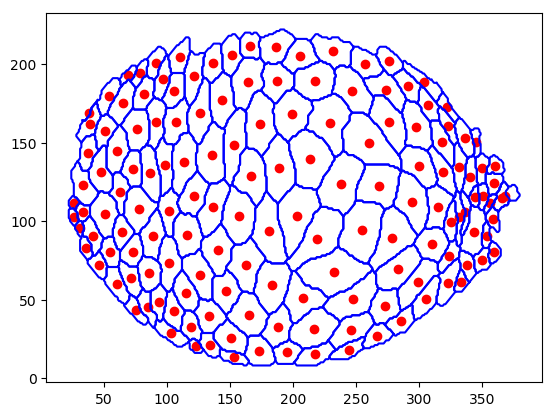

In [122]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull


def calculate_polygon_pixels_and_centroid(x_coords, y_coords):
    # Define el polígono usando ImageDraw
    image = Image.new('L', (max(x_coords)+1, max(y_coords)+1), 0)
    ImageDraw.Draw(image).polygon(list(zip(x_coords, y_coords)), outline=0, fill=1)
    
    # Encuentra los píxeles dentro del polígono
    pixels = np.array(image).nonzero()
    pixel_count = len(pixels[0])
    
    # Calcula el centroide
    centroid_x = np.mean(pixels[1])
    centroid_y = np.mean(pixels[0])

    return pixel_count, (centroid_x, centroid_y)


data=info_limitada
frame_id = '0'
cell_properties = {}

# Por cada célula en el frame
for cell_id, cell_info in data[frame_id].items():
    cell_pressure = cell_info['_pressure']
    cell_edges = cell_info['edges']

    # Por cada borde de la célula
    for edge in cell_edges:
        edge_tension = edge['Tension']
        edge_x_coords = edge['x_co_ords']
        edge_y_coords = edge['y_co_ords']

        # Plot de los bordes
        plt.plot(edge_x_coords, edge_y_coords, color='blue')

    # Reúne todas las coordenadas de los bordes para calcular el centroide de la célula
    all_x_coords = [edge['x_co_ords'] for edge in cell_edges]
    all_y_coords = [edge['y_co_ords'] for edge in cell_edges]

    # Aplanar las listas
    all_x_coords = [x for sublist in all_x_coords for x in sublist]
    all_y_coords = [y for sublist in all_y_coords for y in sublist]

    # Ordenar los puntos para formar un polígono
    points = np.array([all_x_coords, all_y_coords]).T
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]

    # Calcula el área y el centroide
    area, (center_x, center_y) = calculate_polygon_pixels_and_centroid(polygon_points[:,0], polygon_points[:,1])

    # Guarda las propiedades de la célula
    cell_properties[cell_id] = {
        "area": area,
        "centroid": (center_x, center_y),
    }

    # Plot del centroide
    plt.scatter(center_x, center_y, color='red')


# Imprime las propiedades de las células
for cell_id, properties in cell_properties.items():
    print(f"Cell ID: {cell_id}, Area: {properties['area']}, Centroid: {properties['centroid']}")


In [24]:
import numpy as np
import matplotlib.pyplot as plt
def calculate_stress_tensor(cell_info, cell_properties):
    cell_area = cell_properties["area"]
    cell_centroid = cell_properties["centroid"]
    cell_pressure = cell_info['_pressure']
    cell_edges = cell_info['edges']

    # Initialize stress tensor as 2x2 zero matrix
    stress_tensor = np.zeros((2, 2))

    # First part of the stress tensor calculation (pressure)
    stress_tensor -= np.abs(cell_pressure) * cell_area * np.eye(2)

    # Second part of the stress tensor calculation (tension)
    for edge in cell_edges:
        edge_tension = edge['Tension']
        edge_x_coords = edge['x_co_ords']
        edge_y_coords = edge['y_co_ords']

        # Calculate the edge direction vector and its length
        l_ij = np.array([edge_x_coords[-1] - edge_x_coords[0], edge_y_coords[-1] - edge_y_coords[0]])
        l_ij_norm = np.linalg.norm(l_ij)

        # Add this edge's contribution to the stress tensor
        stress_tensor += edge_tension * np.outer(l_ij, l_ij) / l_ij_norm

    # Divide by the cell area
    stress_tensor /= cell_area

    # Calculate eigenvectors (principal stresses)
    eigenvalues, eigenvectors = np.linalg.eig(stress_tensor)

    return stress_tensor, eigenvalues, eigenvectors

data=info_limitada
frame_id = '0'
cell_properties = {}

# Por cada célula en el frame
for cell_id, cell_info in data[frame_id].items():
    cell_pressure = cell_info['_pressure']
    cell_edges = cell_info['edges']

    # Por cada borde de la célula
    for edge in cell_edges:
        edge_tension = edge['Tension']
        edge_x_coords = edge['x_co_ords']
        edge_y_coords = edge['y_co_ords']
        
        
        plt.gca().invert_yaxis()
        # Plot de los bordes
        plt.plot(edge_x_coords, edge_y_coords, color='blue')

    # Reúne todas las coordenadas de los bordes para calcular el centroide de la célula
    all_x_coords = [edge['x_co_ords'] for edge in cell_edges]
    all_y_coords = [edge['y_co_ords'] for edge in cell_edges]

    # Aplanar las listas
    all_x_coords = [x for sublist in all_x_coords for x in sublist]
    all_y_coords = [y for sublist in all_y_coords for y in sublist]

    # Ordenar los puntos para formar un polígono
    points = np.array([all_x_coords, all_y_coords]).T
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]

    # Calcula el área y el centroide
    area, (center_x, center_y) = calculate_polygon_pixels_and_centroid(polygon_points[:,0], polygon_points[:,1])

    # Guarda las propiedades de la célula
    cell_properties[cell_id] = {
        "area": area,
        "centroid": (center_x, center_y),
    }
    
    scale=300
    

    # Calculate stress tensor and its eigenvalues and eigenvectors
    stress_tensor, eigenvalues, eigenvectors = calculate_stress_tensor(cell_info, cell_properties[cell_id])

    # Plot stress vectors
    for i in range(2):
        plt.arrow(center_x, center_y, eigenvalues[i] * eigenvectors[:,i][0]*scale, scale*eigenvalues[i] * eigenvectors[:,i][1], color='green')


KeyError: '0'

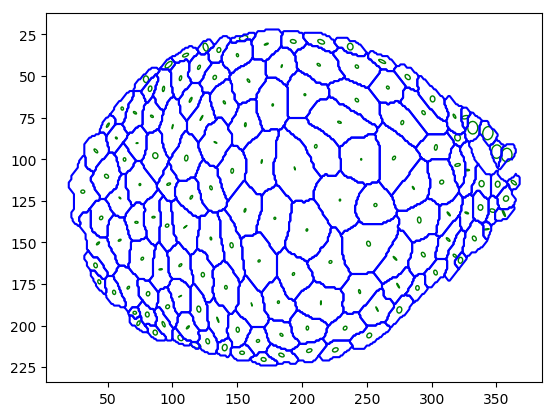

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def calculate_stress_tensor(cell_info, cell_properties):
    cell_area = cell_properties["area"]
    cell_centroid = cell_properties["centroid"]
    cell_pressure = cell_info['_pressure']
    cell_edges = cell_info['edges']
    

    # Initialize stress tensor as 2x2 zero matrix
    stress_tensor = np.zeros((2, 2))
    # First part of the stress tensor calculation (pressure)
    stress_tensor -= np.abs(cell_pressure) * cell_area * np.eye(2)

    # Second part of the stress tensor calculation (tension)
    for edge in cell_edges:
        edge_tension = edge['Tension']
        edge_x_coords = edge['x_co_ords']
        edge_y_coords = edge['y_co_ords']

        # Calculate the edge direction vector and its length
        l_ij = np.array([edge_x_coords[-1] - edge_x_coords[0], edge_y_coords[-1] - edge_y_coords[0]])
        l_ij_norm = np.linalg.norm(l_ij)
        
        # Add this edge's contribution to the stress tensor
        stress_tensor += edge_tension * np.outer(l_ij, l_ij) / l_ij_norm

    # Divide by the cell area
    stress_tensor /= cell_area

    # Calculate eigenvectors (principal stresses)
    eigenvalues, eigenvectors = np.linalg.eig(stress_tensor)

    return stress_tensor, eigenvalues, eigenvectors

data = info_limitada
frame_id = '8'
cell_properties = {}

fig, ax = plt.subplots()

# Establecer un límite superior para los vectores
vector_limit = 1000

# Por cada célula en el frame
for cell_id, cell_info in data[frame_id].items():
    cell_pressure = cell_info['_pressure']
    cell_edges = cell_info['edges']

    # Por cada borde de la célula
    for edge in cell_edges:
        edge_tension = edge['Tension']
        edge_x_coords = edge['x_co_ords']
        edge_y_coords = edge['y_co_ords']

        # Plot de los bordes
        plt.plot(edge_x_coords, edge_y_coords, color='blue')

    # Reúne todas las coordenadas de los bordes para calcular el centroide de la célula
    all_x_coords = [edge['x_co_ords'] for edge in cell_edges]
    all_y_coords = [edge['y_co_ords'] for edge in cell_edges]

    # Aplanar las listas
    all_x_coords = [x for sublist in all_x_coords for x in sublist]
    all_y_coords = [y for sublist in all_y_coords for y in sublist]

    # Ordenar los puntos para formar un polígono
    points = np.array([all_x_coords, all_y_coords]).T
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]

    # Calcula el área y el centroide
    area, (center_x, center_y) = calculate_polygon_pixels_and_centroid(polygon_points[:,0], polygon_points[:,1])

    # Guarda las propiedades de la célula
    cell_properties[cell_id] = {
        "area": area,
        "centroid": (center_x, center_y),
    }


    # Calculate stress tensor and its eigenvalues and eigenvectors
    stress_tensor, eigenvalues, eigenvectors = calculate_stress_tensor(cell_info, cell_properties[cell_id])
    
    scale=10
    # Si la magnitud de ambos vectores propios es menor que el límite, añadir la elipse al gráfico
    if np.all(np.abs(eigenvalues) < vector_limit):
        # Calculate the angle in degrees
        angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]) * 180 / np.pi

        # Create an ellipse
        ellipse = Ellipse((center_x, center_y), width=scale *2 * np.sqrt(np.abs(eigenvalues[0])), height=scale* 2 * np.sqrt(np.abs(eigenvalues[1])), angle=angle, fill=False, color='green')

        # Add the ellipse to the plot
        ax.add_patch(ellipse)
plt.gca().invert_yaxis()
plt.show()

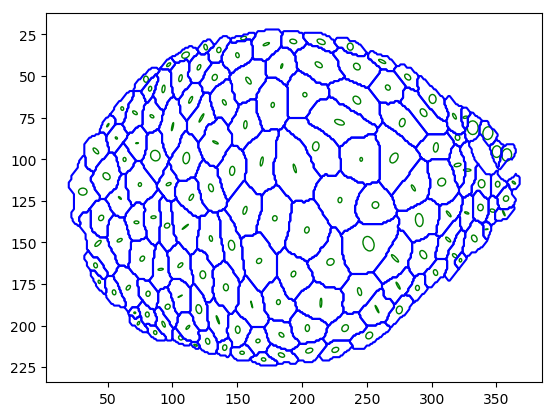

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.patches import Ellipse
from PIL import Image, ImageDraw

def calculate_polygon_pixels_and_centroid(x_coords, y_coords):
    image = Image.new('L', (max(x_coords)+1, max(y_coords)+1), 0)
    ImageDraw.Draw(image).polygon(list(zip(x_coords, y_coords)), outline=0, fill=1)
    pixels = np.array(image).nonzero()
    pixel_count = len(pixels[0])
    centroid_x = np.mean(pixels[1])
    centroid_y = np.mean(pixels[0])
    return pixel_count, (centroid_x, centroid_y)

def calculate_stress_tensor(cell_info, cell_properties, total_area):
    stress_tensor = np.zeros((2, 2))
    for edge in cell_info['edges']:
        vector_ij = np.array([edge['x_co_ords'][-1] - edge['x_co_ords'][0], edge['y_co_ords'][-1] - edge['y_co_ords'][0]])
        T = edge['Tension']
        stress_tensor += T * np.outer(vector_ij, vector_ij) / np.linalg.norm(vector_ij)
    stress_tensor -= cell_info['_pressure']* cell_properties["area"] * np.eye(2)
    
    stress_tensor=stress_tensor/total_area
    eigenvalues, eigenvectors = np.linalg.eig(stress_tensor)
    return stress_tensor, eigenvalues, eigenvectors

data=info_limitada
frame_id = '8'
cell_properties = {}

fig, ax = plt.subplots()

vector_limit = 100

# Compute the total tissue area
total_area = 0

for cell_id, cell_info in data[frame_id].items():
    cell_edges = cell_info['edges']
    all_x_coords = [edge['x_co_ords'] for edge in cell_edges]
    all_y_coords = [edge['y_co_ords'] for edge in cell_edges]
    all_x_coords = [x for sublist in all_x_coords for x in sublist]
    all_y_coords = [y for sublist in all_y_coords for y in sublist]
    points = np.array([all_x_coords, all_y_coords]).T
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    area, (center_x, center_y) = calculate_polygon_pixels_and_centroid(polygon_points[:,0], polygon_points[:,1])
    total_area += area

# Iterate over cells again
for cell_id, cell_info in data[frame_id].items():
    cell_pressure = cell_info['_pressure']
    cell_edges = cell_info['edges']

    for edge in cell_edges:
        edge_tension = edge['Tension']
        edge_x_coords = edge['x_co_ords']
        edge_y_coords = edge['y_co_ords']
        plt.plot(edge_x_coords, edge_y_coords, color='blue')

    all_x_coords = [edge['x_co_ords'] for edge in cell_edges]
    all_y_coords = [edge['y_co_ords'] for edge in cell_edges]
    all_x_coords = [x for sublist in all_x_coords for x in sublist]
    all_y_coords = [y for sublist in all_y_coords for y in sublist]
    points = np.array([all_x_coords, all_y_coords]).T
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    area, (center_x, center_y) = calculate_polygon_pixels_and_centroid(polygon_points[:,0], polygon_points[:,1])
    cell_properties[cell_id] = {"area": area, "centroid": (center_x, center_y)}

    stress_tensor, eigenvalues, eigenvectors = calculate_stress_tensor(cell_info, cell_properties[cell_id], total_area)
    
    scale=200
    if np.all(np.abs(eigenvalues) < vector_limit):
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        ellipse = Ellipse((center_x, center_y), width=scale* 2 * np.sqrt(np.abs(eigenvalues[0])), height=scale* 2 * np.sqrt(np.abs(eigenvalues[1])), angle=angle, fill=False, color='green')
        ax.add_patch(ellipse)
plt.gca().invert_yaxis()
plt.show()
